In [1]:
import cv2
import numpy as np
import math
from math import atan2, cos, sin, sqrt, pi
from itertools import combinations

In [2]:
from matplotlib import pyplot as plt

In [3]:
def detect(image_file):
    
     # Load the image
    img = cv2.imread(image_file)   
    
    # Convert to grayscale.
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    task_board_img, angle_deg = detect_task_board(img)
    blue_button_img, blue_coord = detect_blue_button(img)
    
    print("FINAL ------------------")
    print("angle_deg      | ", angle_deg)
    print("button_centres | ", blue_coord)
    
#     for matplotlib on jupyter notebook
    blue_button_img = cv2.cvtColor(blue_button_img, cv2.COLOR_BGR2RGB)
    plt.imshow(blue_button_img)
    plt.title('my picture')
    plt.show()
    
    
#     cv2.imshow("Detected Blue Start Button", blue_button_img)
# #     cv2.imshow("Detected Task Board", task_board_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    
    return angle_deg, blue_coord

In [24]:
def get_blue_coord(hough_circles):
    circles = np.array(hough_circles)
    x_components = circles[0][:]
    
    blue_coord = None
    
    for pair in list(combinations(x_components, 2)):
        diff_x = abs(pair[0][0] - pair[1][0])
#         print(diff_x)
        if 18 < diff_x < 22:
            print(pair)
            if pair[0][0] > pair[1][0]:
                blue_coord = pair[0]
#                 return blue_coord
            else:
                blue_coord = pair[1]
    if blue_coord:
        return blue_coord


def detect_blue_button(img):
    
#      # Load the image
#     img = cv2.imread(image_file)   
    
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur using 3 * 3 kernel.
#     gray_blurred = cv2.blur(gray, (3, 3))
#     gray_blurred = gray

    # Apply Hough transform on the blurred image.
    detected_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10, 
                                        param1 = 50, param2 = 30, minRadius = 9, maxRadius = 15)

    if detected_circles is not None:
        try:
            blue_button_coordinates = get_blue_coord(detected_circles)
            print(blue_button_coordinates)

            # Convert the circle parameters a, b and r to integers.
            pt = np.uint16(np.around(blue_button_coordinates))

            a, b, r = pt[0], pt[1], pt[2]

            # Draw the circumference of the circle.
            cv2.circle(img, (a, b), r, (0, 255, 0), 2)

            # Draw a small circle (of radius 1) to show the center.
            cv2.circle(img, (a, b), 1, (0, 0, 255), 3)
            
        except Exception as e:
            print(e)
            print("taking blue button coordinates as (0,0) as not able to detect")
            blue_button_coordinates = [0,0,1]
            pt = blue_button_coordinates
            a, b, r = pt[0], pt[1], pt[2]
            
    return img, (a, b)


def drawAxis(img, p_, q_, color, scale):
    p = list(p_)
    q = list(q_)

    ## [visualization1]
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))

    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)

    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)

    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
    ## [visualization1] 

def getOrientation(pts, img):
    ## [pca]
    # Construct a buffer used by the pca analysis
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]

    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)

    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    ## [pca]

    ## [visualization]
    # Draw the principal components
    cv2.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    drawAxis(img, cntr, p1, (255, 255, 0), 1)
    drawAxis(img, cntr, p2, (0, 0, 255), 5)

    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    angle_rad = angle
    angle_deg = -np.rad2deg(angle)
    ## [visualization]

    # Label with the rotation angle
    label = "  Rotation Angle: " + str(angle_deg) + " degrees"
    textbox = cv2.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
    cv2.putText(img, label, (cntr[0], cntr[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)

    return angle_rad, angle_deg


def detect_task_board(img):

#     # Load the image
#     img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert image to binary
    _, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Find all the contours in the thresholded image
    contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for i, c in enumerate(contours):

        # Calculate the area of each contour
        area = cv2.contourArea(c)
        
        # Ignore contours that are too small or too large
        if area < 3700 or 100000 < area:
#         if 83000 < area < 84500:
            continue
        
#         img = detect_buttons(image)
        print("area", area)
        # Draw each contour only for visualisation purposes
        cv2.drawContours(img, contours, i, (0, 0, 255), 2)

        # Find the orientation of each shape
        angle_rad, angle_deg = getOrientation(c, img)
    
    return img, angle_deg




area 83808.5
[449.5 241.5   9.6]
FINAL ------------------
angle_deg      |  -11.512152306424703
button_centres |  (450, 242)


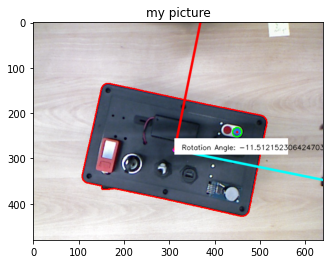

In [11]:
# image_name = "frame1.jpg"
image_name = "frame100.jpg"
# image_name = "frame175.jpg"
# image_name = "zero_image.png"

images_dir = "/home/nemo/code/repos/robothon/code_repos/notebooks/"
image_path = images_dir + image_name

angle_deg, blue_coord = detect(image_path)

area 84379.5
[377.5 188.5  13.2]
FINAL ------------------
angle_deg      |  18.677282573583373
button_centres |  (378, 188)


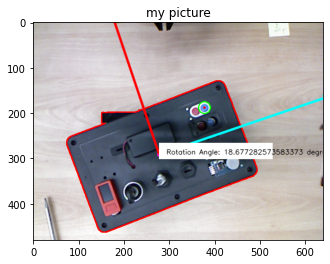

In [12]:
image_name = "frame1.jpg"
images_dir = "/home/nemo/code/repos/robothon/code_repos/notebooks/"
image_path = images_dir + image_name

angle_deg, blue_coord = detect(image_path)

area 86820.0
[405.5 215.5   9.6]
FINAL ------------------
angle_deg      |  7.5146779467540945
button_centres |  (406, 216)


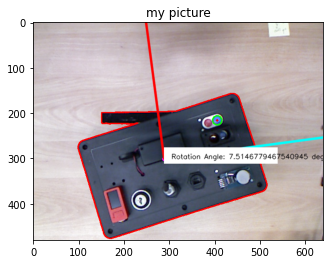

In [13]:
image_name = "frame174.jpg"
images_dir = "/home/nemo/code/repos/robothon/code_repos/notebooks/"
image_path = images_dir + image_name

angle_deg, blue_coord = detect(image_path)

area 84810.5
[374.5 220.5   9.6]
FINAL ------------------
angle_deg      |  8.849568154999831
button_centres |  (374, 220)


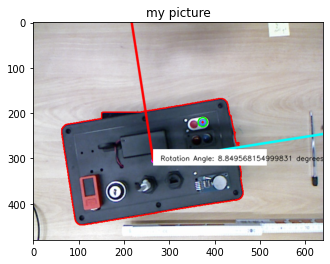

In [14]:
image_name = "frame245.jpg"
images_dir = "/home/nemo/code/repos/robothon/code_repos/notebooks/"
image_path = images_dir + image_name

angle_deg, blue_coord = detect(image_path)

area 89462.0
None
loop of ufunc does not support argument 0 of type NoneType which has no callable rint method
taking blue button coordinates as (0,0) as not able to detect
FINAL ------------------
angle_deg      |  -79.7321922557366
button_centres |  (0, 0)


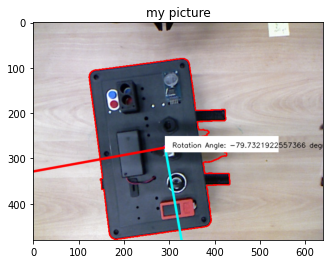

In [25]:
image_name = "frame43.jpg"
images_dir = "/home/nemo/code/repos/robothon/code_repos/notebooks/"
image_path = images_dir + image_name

angle_deg, blue_coord = detect(image_path)